<a href="https://colab.research.google.com/github/rsamant07/AdvComputerVision/blob/main/C3_W1_Lab_2_Transfer_Learning_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Transfer Learning
In this notebook, you will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



## Run in Google Colab: GPU setup
The training portion of this notebook will be faster in google colab using a GPU. 
- You can click on the "open in colab" link above to open the notebook in a colab.
- Within the Colab, go to the colab's menu "Runtime" -> "Change runtime type".  A popup will appear with a menu to select "None", "GPU" or "TPU".

## Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


## Parameters

- Define the batch size
- Define the class (category) names

In [ ]:
BATCH_SIZE = 32 
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help you to create some visualizations. (These will be used later)

In [ ]:
#@title Visualization Utilities[RUN ME]
#Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")
# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. You will load the dataset from Keras.

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


### Visualize Dataset

Use the `display_image` to view some of the images and their class labels.

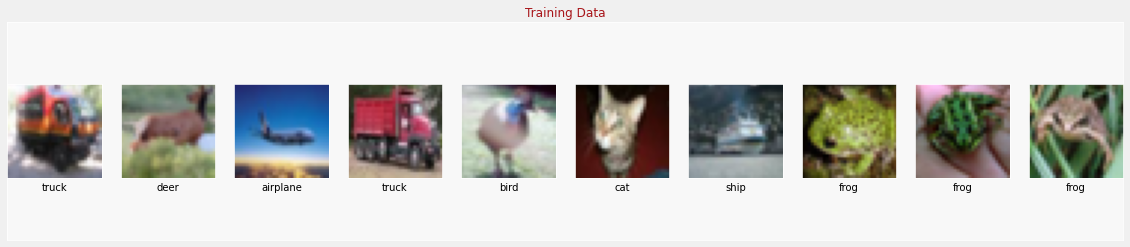

In [ ]:
display_images(training_images, training_labels, training_labels, "Training Data" )

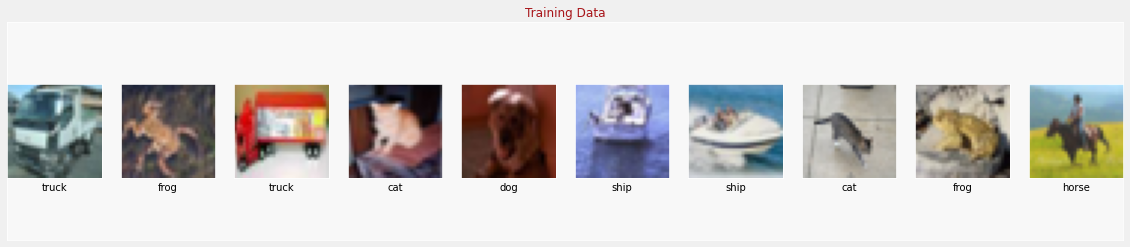

In [ ]:
display_images(validation_images, validation_labels, validation_labels, "Training Data" )

### Preprocess Dataset
Here, you'll perform normalization on images in training and validation set. You'll use [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) of ResNet50 in Keras.

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [ ]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
You will be performing transfer learning on **ResNet50** available in Keras.
- You'll load pre-trained **imagenet weights** to the model.
- You'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Connects the feature extraction and final classification layers to build the final model.
Since input image size is (32 x 32) we simply upsample the image by factor of (7x7) to transform it to (224 x 224)
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Defines the final model and compiles it. We opt to use Stochastic Gradient Descent as the optimizer and Sparse Categorical CrossEntropy as the lposs function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_______________________________________________________

## Train the model

In [ ]:
EPOCHS = 5
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/5
782/782 [==============================] - 266s 340ms/step - loss: 0.4085 - accuracy: 0.8663 - val_loss: 0.2103 - val_accuracy: 0.9282
Epoch 2/5
782/782 [==============================] - 265s 339ms/step - loss: 0.1020 - accuracy: 0.9674 - val_loss: 0.1957 - val_accuracy: 0.9368
Epoch 3/5
782/782 [==============================] - 265s 339ms/step - loss: 0.0358 - accuracy: 0.9894 - val_loss: 0.1651 - val_accuracy: 0.9485
Epoch 4/5
782/782 [==============================] - 265s 339ms/step - loss: 0.0141 - accuracy: 0.9970 - val_loss: 0.1686 - val_accuracy: 0.9526
Epoch 5/5
782/782 [==============================] - 265s 339ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.1776 - val_accuracy: 0.9523


## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evalute` function.

In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 16s 101ms/step - loss: 0.1776 - accuracy: 0.9523


### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

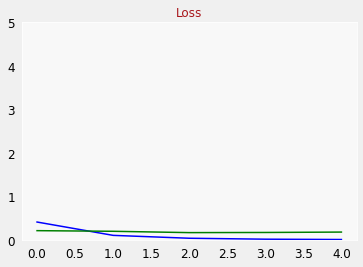

In [ ]:
plot_metrics("loss", "Loss")

Plot the training accuracy (blue) as well as the validation accuracy (green).

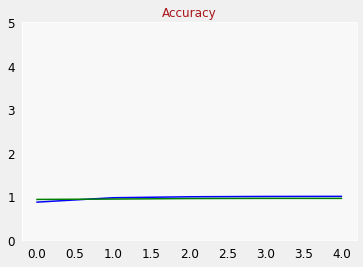

In [ ]:
plot_metrics("accuracy", "Accuracy")

### Visualize predictions
You can take a look at the predictions on the validation set.

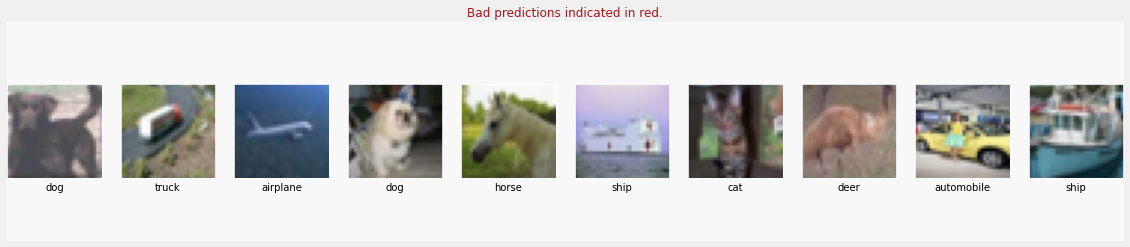

In [ ]:
probabilities = model.predict(valid_X, batch_size=64)
probabilities = np.argmax(probabilities, axis = 1)

display_images(validation_images, probabilities, validation_labels, "Bad predictions indicated in red.")